`f_` is the intended order to go through the notebooks if I forgot what I did in the future.

In [1]:
import util_thm
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import os

# Inverting the $\beta, S$ conjugate pair
Having nonzero interaction doesn't change how we do this, as is the case for matching.

## Reading data (jump here to change params)
Let's first start with the full $N - S_{tot}$ space scan for a fixed set of model parameters. The folder names are a bit different from NI, otherwise things are the same.

In [26]:
tnpspc = {  # tenpy specs used to generate folder names
    "geometry": "sawtooth",
    "spin": "spinless",      # "spinful", "spinless"
    "interacting": "I",             # "I", "NI"
    "L": 25,
    "chi": 64,
}
model_params = {
    "V": 0.1,
    "shift": -2,
    "tp": 1.41421356237,
    "n_s": 0.7,#np.arange(0.3, 0.54, 0.02)
}

In [27]:
# folder_name = f"{tnpspc['geometry']}_{tnpspc['spin']}_{tnpspc['interacting']}_L{tnpspc['L']}_chi{tnpspc['chi']}"
folder_name = f"ST_SL_I_L25_t1_tpsqrt2_shf{model_params['shift']}_V{model_params['V']}_chi64"
csv_name = f"V{model_params['V']}_tp{model_params['tp']}_shift{model_params['shift']}_ns{model_params['n_s']}.csv"
csv_path = Path(r"C:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\projects\flat_band_cooling\tenpy_results\matching_results",
                folder_name, csv_name)
df_match = pd.read_csv(csv_path)

# df_match

In [28]:
L_subregion = tnpspc['L']
N_s = model_params["n_s"] * 2 * L_subregion
beta_vals = df_match["beta"].to_numpy(dtype=float)
mask_beta = np.isclose(beta_vals, 20)
s2_tot_max_beta = df_match[mask_beta]["S2_tot"].to_numpy(dtype=float)
Ntot_max_beta = df_match[mask_beta]["Ntot"].to_numpy(dtype=float)

## The tamed flat-ish band
We no longer expect the band to be exactly flat (as shown in the broadening of the high Renyi entropy feature around $\mu = V/2$).

In [29]:
N_range = np.arange(N_s + 0.4 * L_subregion, N_s + 2 * L_subregion)
S_range = np.linspace(0., 20.0, 100) * (L_subregion / 25)

See `f1` for notes on interpolation.

In [30]:
N_N_pts = len(N_range)
N_S_pts = len(S_range)
n_r_range = (N_range - N_s) / (2 * L_subregion)

### Plots
A few things to notice: (looking at $V = 1$)
* I only get solutions at where $n_r$ is much closer to $n_s$ than before.
* The amount of cooling I get is in general much less, and I don't always get cooling for $n_r > n_s$: $n_s = 0.5$ seems like a special case
* I need much smaller $S_{tot}$ to see cooling.
* $V_{offset} are almost horizontal lines.

In [31]:
beta_all, mu_glob_all = util_thm.invert_NS_mat_df(df_match, N_range, S_range, "mu_glob")
_       , V_offset_all = util_thm.invert_NS_mat_df(df_match, N_range, S_range, "V_offset")
_       , s2_s_all = util_thm.invert_NS_mat_df(df_match, N_range, S_range, "s2_s")
_       , s2_r_all = util_thm.invert_NS_mat_df(df_match, N_range, S_range, "s2_r")
_       , varsigma_all = util_thm.invert_NS_mat_df(df_match, N_range, S_range, "varsigma")

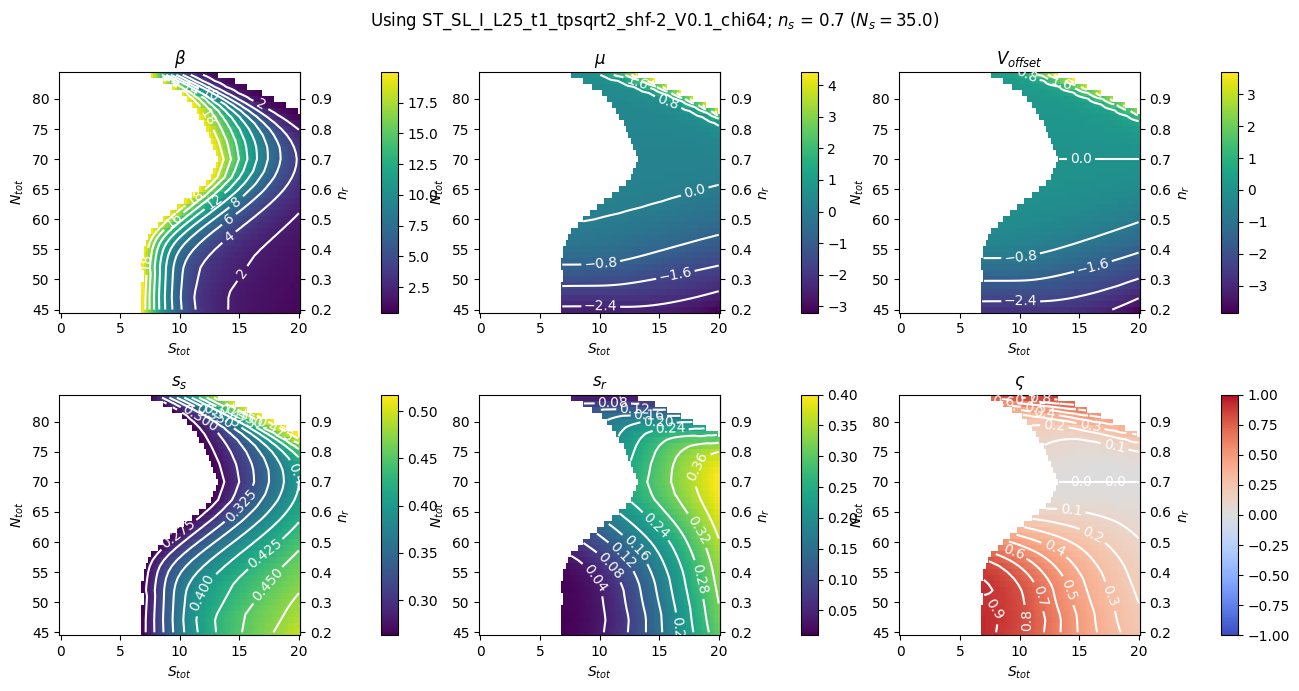

In [32]:
fig_fixS, axs_fixS_all = plt.subplots(2, 3 * 2, figsize = (13, 7), gridspec_kw = {"width_ratios": [15, 1] * 3})
axs_fixS = axs_fixS_all[:, ::2]
axs_fixS_cb = axs_fixS_all[:,1::2]

for ax, ax_cb, params_mat, cmap, str_label, clim in zip(
        axs_fixS.flatten(),
        axs_fixS_cb.flatten(),
        [beta_all, mu_glob_all, V_offset_all, s2_s_all, s2_r_all, varsigma_all],
        ["viridis", "viridis", "viridis", "viridis", "viridis", "coolwarm"],
        [r"$\beta$", r"$\mu$", r"$V_{offset}$", r"$s_s$", r"$s_r$", r"$\varsigma$"],
        [None, None, None, None, None, (-1, 1)]):
    img = ax.pcolormesh(S_range, N_range, params_mat, clim = clim, cmap = cmap)
    ax.set_box_aspect(1)
    ax.set_title(str_label)
    ax.set_xlabel(r"$S_{tot}$")
    ax.set_ylabel(r"$N_{tot}$")
    ryax = ax.secondary_yaxis('right', functions = (lambda x: (x - N_s) / (2 * L_subregion), lambda x: x * 2 * L_subregion + N_s))
    ryax.set_ylabel(r"$n_r$")
    cntr = ax.contour(S_range, N_range, params_mat, colors = "white", linestyles = "solid", levels = 10)
    ax.clabel(cntr, inline = True)
    fig_fixS.colorbar(img, cax = ax_cb, fraction = 0.5, location = 'right')

    # Plot some limitations set by either physical argument or EoS available
    # ax.plot(s2_tot_max_beta, Ntot_max_beta, color = "blue", ls = "--")  # EoS available
fig_fixS.suptitle(rf"Using {folder_name}; $n_s$ = {model_params['n_s']} ($N_s =${N_s})")
fig_fixS.tight_layout(w_pad = 0.1)

Still don't know what to do with these constant $V_{offset}$ plots.

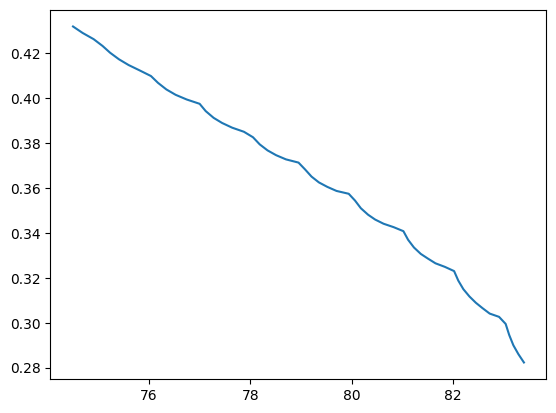

In [33]:
N_curve, s_s_curve = util_thm.slice_constant_V(N_range, S_range, V_offset_all, s2_s_all, 0.3)
plt.plot(N_curve, s_s_curve)

I think it would be interesting to look at $0 < V < 1$ and see how the behaviors we see interpolate.